In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import keras_ocr
import pandas as pd

from PIL import Image

plt.style.use('ggplot')
cv2.ocl.setUseOpenCL(False)

In [ ]:
feature_detection_algo = 'sift'
feature_match = 'bf'

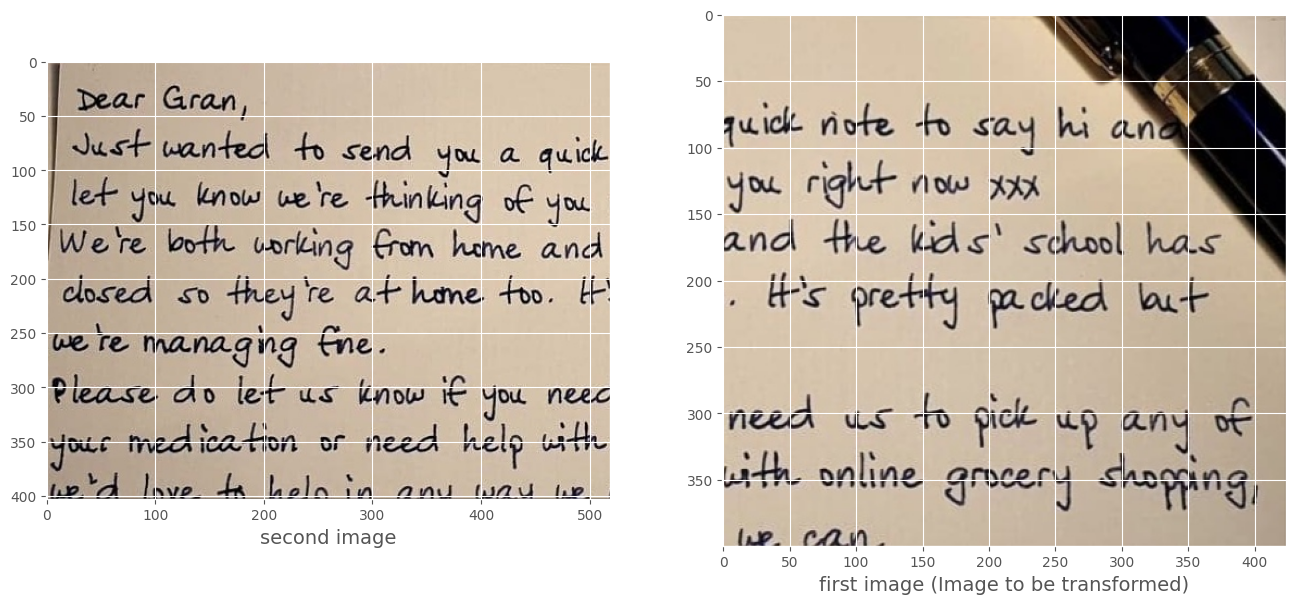

In [ ]:
#  the frist image is the image that will be transformed
first_photo = cv2.imread('/content/sample_data/1.jpeg')

# converting to RGB for Matplotlib
first_photo = cv2.cvtColor(first_photo,cv2.COLOR_BGR2RGB)

# converting to grayscale
first_photo_gray = cv2.cvtColor(first_photo, cv2.COLOR_RGB2GRAY)

# Doing the same for the second image
second_photo = cv2.imread('/content/sample_data/2.jpeg')
second_photo = cv2.cvtColor(second_photo,cv2.COLOR_BGR2RGB)
second_photo_gray = cv2.cvtColor(second_photo, cv2.COLOR_RGB2GRAY)

# plotting the images
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(second_photo, cmap="gray")
ax1.set_xlabel("second image", fontsize=14)

ax2.imshow(first_photo, cmap="gray")
ax2.set_xlabel("first image (Image to be transformed)", fontsize=14)


plt.show()

In [ ]:
#function to determine which feature detection algorithm will be used
def descriptor_method(image, method=None):

    if method == 'sift':
        descriptor = cv2.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()

    (keypoints, features) = descriptor.detectAndCompute(image, None)

    return (keypoints, features)

# **Applying SIFT algorithm to find keypoints and descriptors**

In [ ]:
keypoints_first_img, features_first_img = descriptor_method(first_photo_gray, method=feature_detection_algo)
keypoints_second_img, features_second_img = descriptor_method(second_photo_gray, method=feature_detection_algo)

In [ ]:
#function to create and return a Matcher Object
def create_matching_object(method,crossCheck):
    """
    For BF matcher, first we have to create the BFMatcher object using cv2.BFMatcher().
    It takes two optional params.
    normType : It specifies the distance measurement type
    crossCheck : which is false by default. If it is true, Matcher returns only those matches
    """
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [ ]:
def key_points_matching(features_first_img, features_second_img, method):
    """
    Perform key points matching between the features of the first image and the second image using a specified method.

    Returns:
    rawMatches (list): List of raw matches between the train and query images.
    """
    bf = create_matching_object(method, crossCheck=True)

    # Match descriptors between the two images.
    best_matches = bf.match(features_first_img,features_second_img)

    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches of Brute force):", len(rawMatches))
    return rawMatches

## Finding the matched keypoints using Brute Force technique and draw the matches

Drawing: bf matched features Lines
Raw matches of Brute force): 663


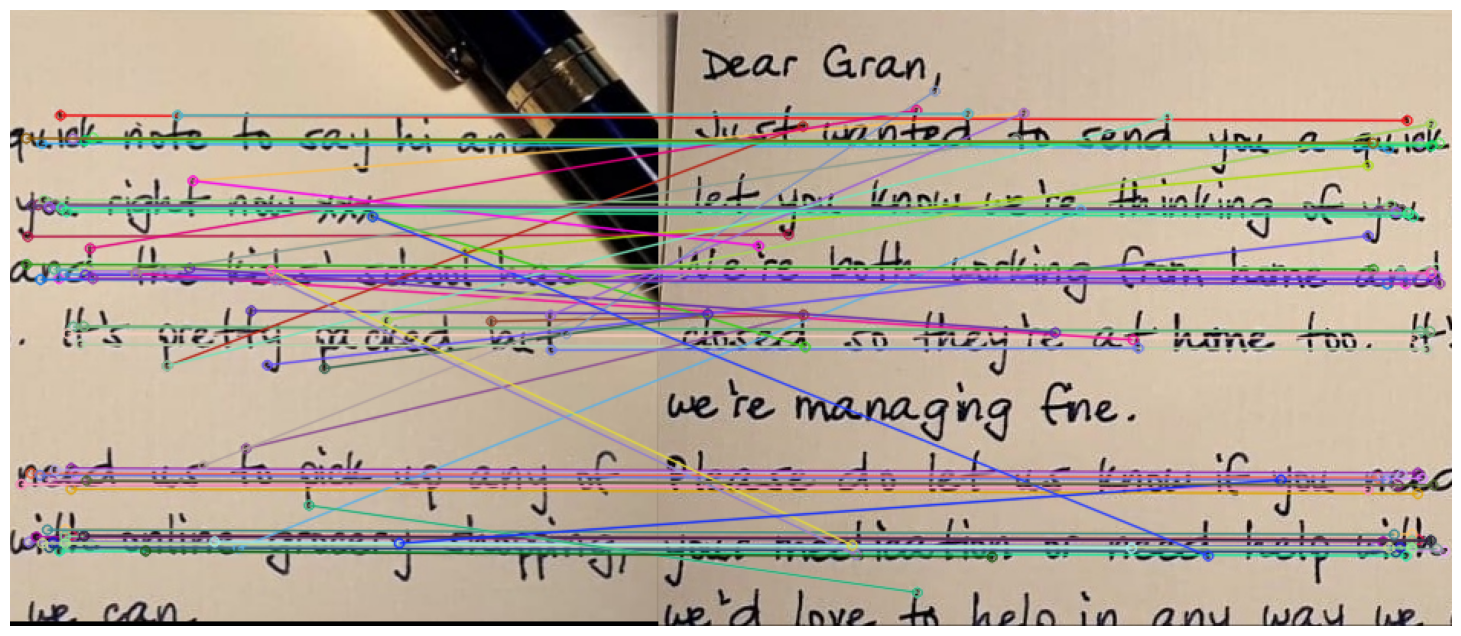

In [ ]:
print("Drawing: {} matched features Lines".format(feature_match))

fig = plt.figure(figsize=(20,8))


matches = key_points_matching(features_first_img, features_second_img, method=feature_detection_algo)

# using cv2.drawmatches function to draw the found matches of keypoints from two images in the output image
mapped_features_image = cv2.drawMatches(first_photo,keypoints_first_img,second_photo,keypoints_second_img,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)



plt.imshow(mapped_features_image)
plt.axis('off')

plt.show()

# Create Homography matrix

In [ ]:
def homography_stitching(keypoints_first_img, keypoints_second_img, matches, reprojThresh):
    """

    Perform homography stitching by calculating the homography matrix.


    Because we are supposed to pass 2 arrays of coordinates to cv2.findHomography, as in I have these points in image-1, and I have points in image-2, so now what is the homography matrix to transform the points from image 1 to image 2


    reprojThresh (float): Reprojection threshold for the RANSAC algorithm.

    Returns:
        tuple: Tuple containing the matches, homography matrix, and status.
               - matches (list): List of matches between key points in the training and query images.
               - H (numpy array): Homography matrix.
               - status (numpy array): Status of inlier points.

    Note:
        The minimum number of matches required for calculating the homography is 4.


    """

    # converting the keypoints to numpy arrays before passing them for calculating Homography Matrix.
    keypoints_first_img = np.float32([keypoint.pt for keypoint in keypoints_first_img])
    keypoints_second_img = np.float32([keypoint.pt for keypoint in keypoints_second_img])

    # For findHomography() - I need to have an assumption of a minimum of correspondence points that are present between the 2 images. Here, I am assuming that Minimum Match Count to be 4
    if len(matches) > 4:
        # construct the two sets of points
        points_first = np.float32([keypoints_first_img[m.queryIdx] for m in matches])
        points_second = np.float32([keypoints_second_img[m.trainIdx] for m in matches])

        # Calculate the homography between the sets of points
        (H, status) = cv2.findHomography(points_first, points_second, cv2.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None

In [ ]:
M = homography_stitching(keypoints_first_img, keypoints_second_img, matches, reprojThresh=4)

if M is None:
    print("Error!")

(matches, Homography_Matrix, status) = M

print(Homography_Matrix)

[[ 1.00101271e+00 -5.54493712e-04  4.56642525e+02]
 [ 1.32053084e-03  9.98592638e-01  3.33687073e+00]
 [ 4.35384402e-06 -1.56864243e-06  1.00000000e+00]]


width  943


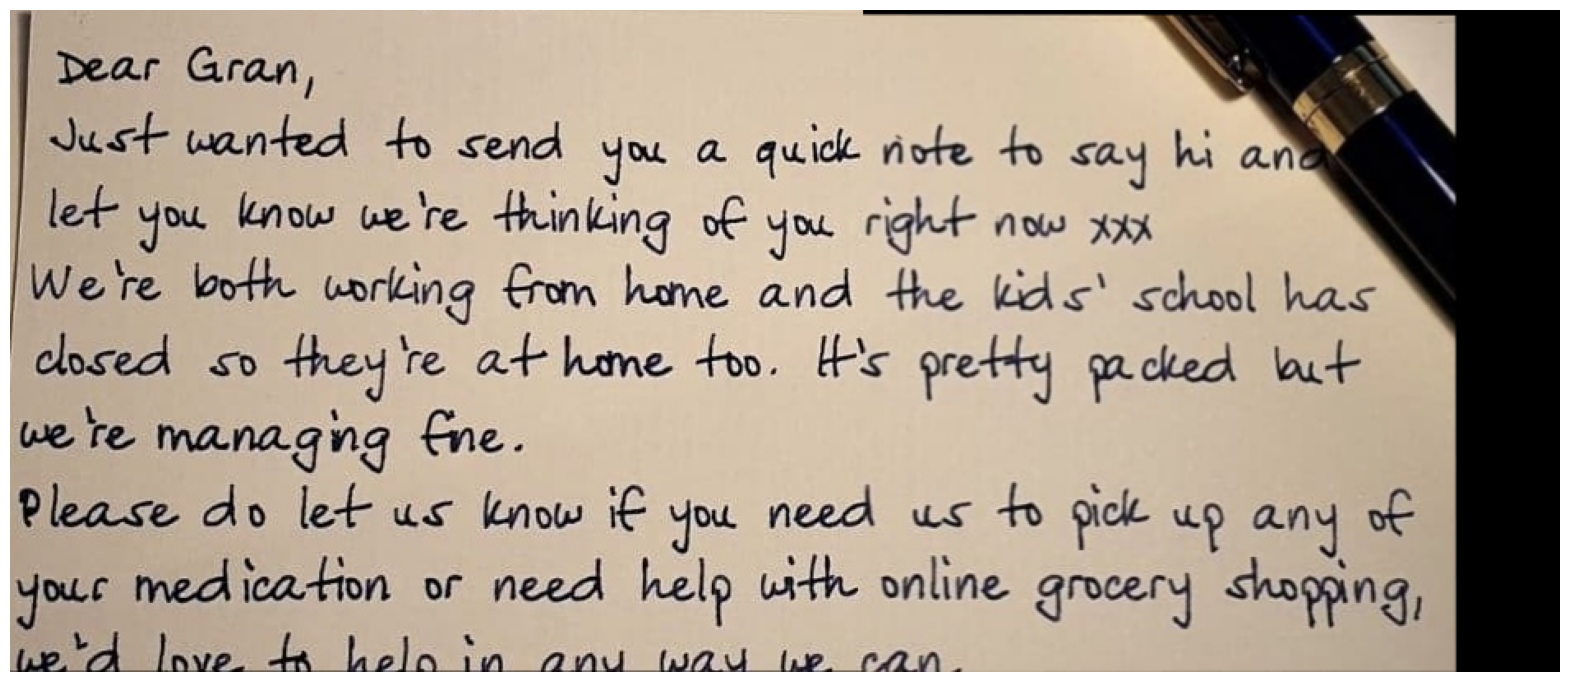

In [ ]:
# calculating the width of the panaromic image by adding the width of the first image to the second one
width = first_photo.shape[1] + second_photo.shape[1]
print("width ", width)


# calculating the height of the panaromic image by choosing the maximum height of both images
height = max(second_photo.shape[0], first_photo.shape[0])

"""
then applying a perspective warp to stitch the images together
by plugging that "Homography_Matrix"  into warpedPerspective and I shall have a warped image1 into image2 frame
The warpPerspective() function returns an image whose size is the same as the size of the original image.
"""
result = cv2.warpPerspective(first_photo, Homography_Matrix,  (width, height))



#Blend the warped image with the original image. This step ensures a smooth transition in the overlapping regions
result[0:second_photo.shape[0], 0:second_photo.shape[1]] = second_photo

plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(result)

imageio.imwrite("./panorama_img_"+'.jpeg', result)

plt.show()

## Applying an OCR model to extract text from the panoramic image

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
3/3 [==============================] - 2s 88ms/step


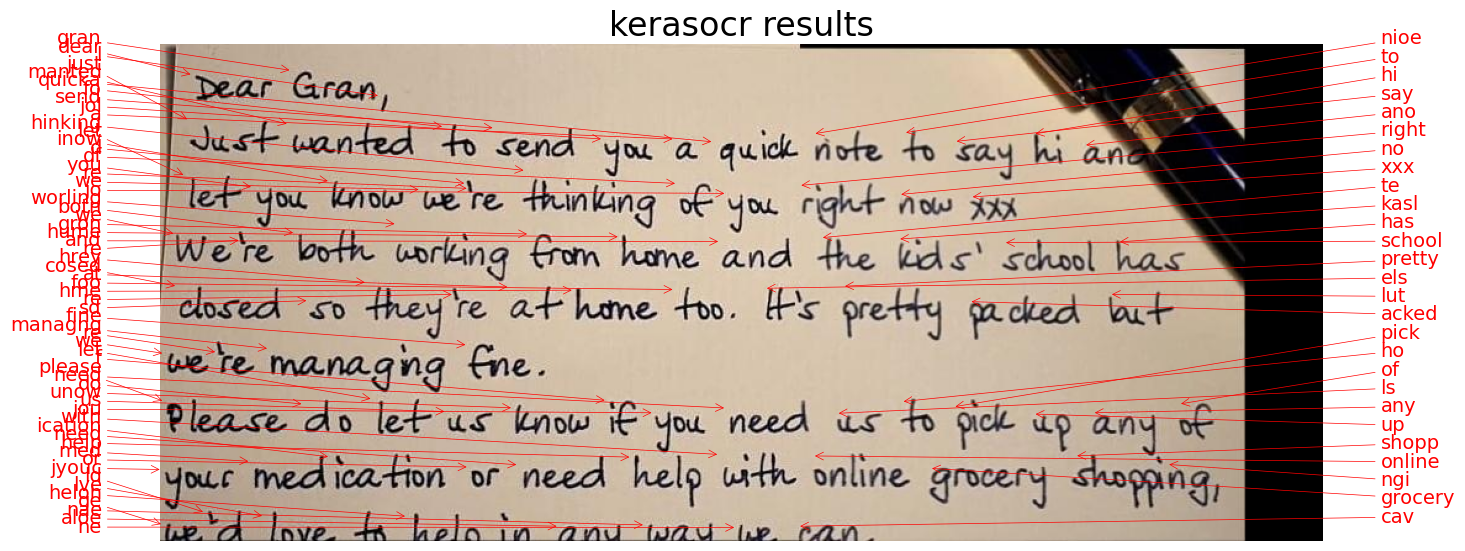

In [ ]:
image = keras_ocr.tools.read('/content/panorama_img_.jpeg')
fig, ax = plt.subplots(1, 1, figsize=(15, 30))
# Create an OCR recognizer
pipeline = keras_ocr.pipeline.Pipeline()
# Perform OCR on the image
prediction_groups = pipeline.recognize([image])
# Draw bounding boxes on the image
keras_ocr.tools.drawAnnotations(image=image, predictions=prediction_groups[0], ax=ax)
ax.set_title('kerasocr results', fontsize=24)

plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
for result in prediction_groups[0]:
  print(result[0])

gran
dear
l
just
manted
fo
send
quicka
nioe
to
hi
jol
a
say
ano
let
hinking
d
inow
right
df
you
re
we
jo
no
xxx
botn
we
gron
worling
hume
and
te
re
kasl
school
has
cosed
at
hrey
els
foo
pretty
hme
lut
re
acked
sd
fine
managng
re
we
let
f
please
ho
do
need
pick
of
unow
us
ls
jou
up
any
with
ication
online
med
need
help
shopp
or
ngi
grocery
jyouc
ld
lve
heloh
ge
nae
aloe
cav
ne
